In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import *
from itertools import islice
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

In [2]:
data = pd.read_excel("TNT Case Data.xls", sheet_name = "AP_Masked Data")

In [3]:
data.shape

(29586, 33)

In [4]:
data.head()

,C.candidateId,Der.Age,C.personalDetails.gender,C.personalDetails.religion,C.personalDetails.caste,C.personalDetails.differentlyAbled,C.sourceOfMobilization.source,C.personalDetails.maritialStatus,C.contactDetails.district,ExpD.employedStatus,C.PreTrainingStatus,Der.Experience,EduD.education,C.TechnicalEducation,B.batchId,B.batchStartDate,B.schemeName,B.schemeId,B.sector.name,B.tpId,B.TCName,B.batchName,B.address.district.name,B.batchfees,AJD.jobName,AJD.nsqfLevel,AJD.qpCode,QPS.qpParamOne.paramDesc,QPS.qpParamThree.paramDesc,QPS.qpParamTwo.paramDesc,AJD.assmtCrt.percentage,AJD.assmtCrt.result,Der.CandidateFromAndra
0,1,20,MALE,Hindu,ST,NO,Self Registration,Unmarried,visakhapatanam,No,Fresher,0,SSC,No,16976,2019-07-19,Scheme -2,Scheme_8,Capital Goods,TP10151,TP10151,Batch-122,Visakhapatnam,0,Manual Metal Arc Welding/ Shielded Metal Arc W...,3.0,QP-756,technical,organized,manufacturing,82.75,PASS,True
1,2,18,MALE,Hindu,SC,NO,Self Registration,Unmarried,cuddapah,No,Fresher,0,SSC,No,798,2018-11-12,Scheme -9,1,Electronics & Hardware,TP_16827,TP_16827,Batch-132,Cuddapah,0,Computer Hardware Assistant,3.0,QP-1430,non-technical,unorganized,manufacturing,57.00,PASS,True
2,3,20,MALE,Hindu,General,NO,Self Registration,Unmarried,cuddapah,No,Fresher,0,ITI,No,798,2018-11-12,Scheme -9,1,Electronics & Hardware,TP_16827,TP_16827,Batch-132,Cuddapah,0,Computer Hardware Assistant,3.0,QP-1430,non-technical,unorganized,manufacturing,87.00,PASS,True
3,4,22,MALE,Hindu,OBC,NO,Self Registration,Unmarried,cuddapah,No,Fresher,0,SSC,No,798,2018-11-12,Scheme -9,1,Electronics & Hardware,TP_16827,TP_16827,Batch-132,Cuddapah,0,Computer Hardware Assistant,3.0,QP-1430,non-technical,unorganized,manufacturing,66.00,PASS,True
4,5,22,MALE,Hindu,OBC,NO,Self Registration,Unmarried,cuddapah,No,Fresher,0,Diploma,No,798,2018-11-12,Scheme -9,1,Electronics & Hardware,TP_16827,TP_16827,Batch-132,Cuddapah,0,Computer Hardware Assistant,3.0,QP-1430,non-technical,unorganized,manufacturing,80.00,PASS,True


In [5]:
data.columns

Index(['C.candidateId', 'Der.Age', 'C.personalDetails.gender',
       'C.personalDetails.religion', 'C.personalDetails.caste',
       'C.personalDetails.differentlyAbled', 'C.sourceOfMobilization.source',
       'C.personalDetails.maritialStatus', 'C.contactDetails.district',
       'ExpD.employedStatus', 'C.PreTrainingStatus', 'Der.Experience',
       'EduD.education', 'C.TechnicalEducation', 'B.batchId',
       'B.batchStartDate', 'B.schemeName', 'B.schemeId', 'B.sector.name',
       'B.tpId', 'B.TCName', 'B.batchName', 'B.address.district.name',
       'B.batchfees', 'AJD.jobName', 'AJD.nsqfLevel', 'AJD.qpCode',
       'QPS.qpParamOne.paramDesc', 'QPS.qpParamThree.paramDesc',
       'QPS.qpParamTwo.paramDesc', 'AJD.assmtCrt.percentage',
       'AJD.assmtCrt.result', 'Der.CandidateFromAndra'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29586 entries, 0 to 29585
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   C.candidateId                       29586 non-null  int64         
 1   Der.Age                             29586 non-null  int64         
 2   C.personalDetails.gender            29586 non-null  object        
 3   C.personalDetails.religion          29583 non-null  object        
 4   C.personalDetails.caste             29583 non-null  object        
 5   C.personalDetails.differentlyAbled  29586 non-null  object        
 6   C.sourceOfMobilization.source       19753 non-null  object        
 7   C.personalDetails.maritialStatus    29586 non-null  object        
 8   C.contactDetails.district           18733 non-null  object        
 9   ExpD.employedStatus                 29586 non-null  object        
 10  C.PreTrainingStatus   

## 1. Use a boxplot to show the distribution of assessment scores per training provider ("B.tpId" represent the training provider id and  "AJD.assmtCrt.percentage"  represents the assessment score).

In [7]:
data['AJD.assmtCrt.percentage'].median()

78.44

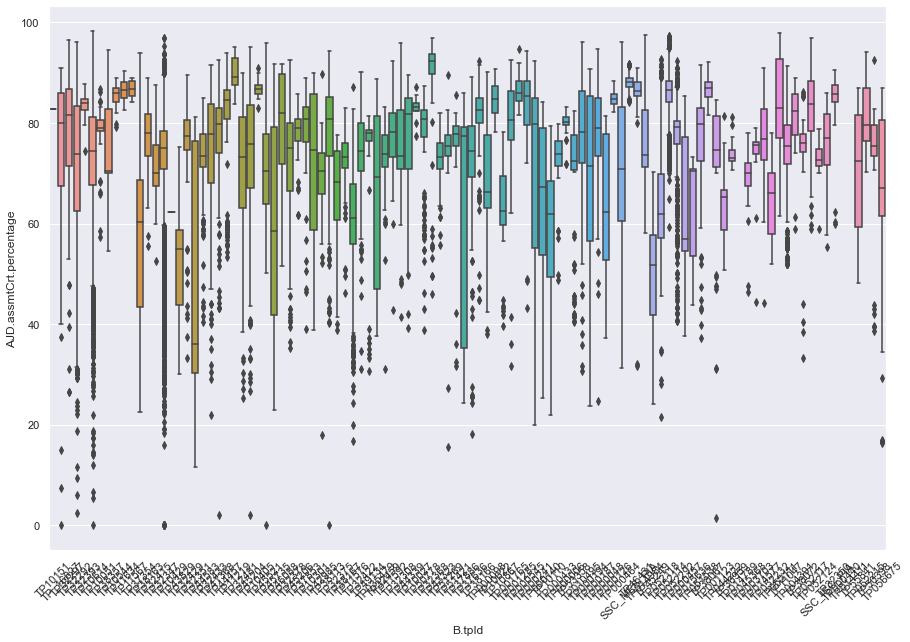

In [8]:
sns.set(rc={'figure.figsize':(15,10)})
box = sns.boxplot(data = data, x = 'B.tpId', y = 'AJD.assmtCrt.percentage')
plt.xticks(rotation=45)
plt.show()

The overall median of the assesment percentage lies around 78.44 for all the trainers for all the candidates in the database

## 2. Use a stacked bar plot to show the number of FAIL/PASS per training provider ("AJD.assmtCrt.result" represents the assessment status which is populated by FAIL/PASS)

In [9]:
data_pass_fail = pd.DataFrame(data.groupby(['B.tpId','AJD.assmtCrt.result'])['AJD.assmtCrt.result'].count().unstack().fillna(0))
data_pass_fail = data_pass_fail.reset_index()

<AxesSubplot:xlabel='B.tpId'>

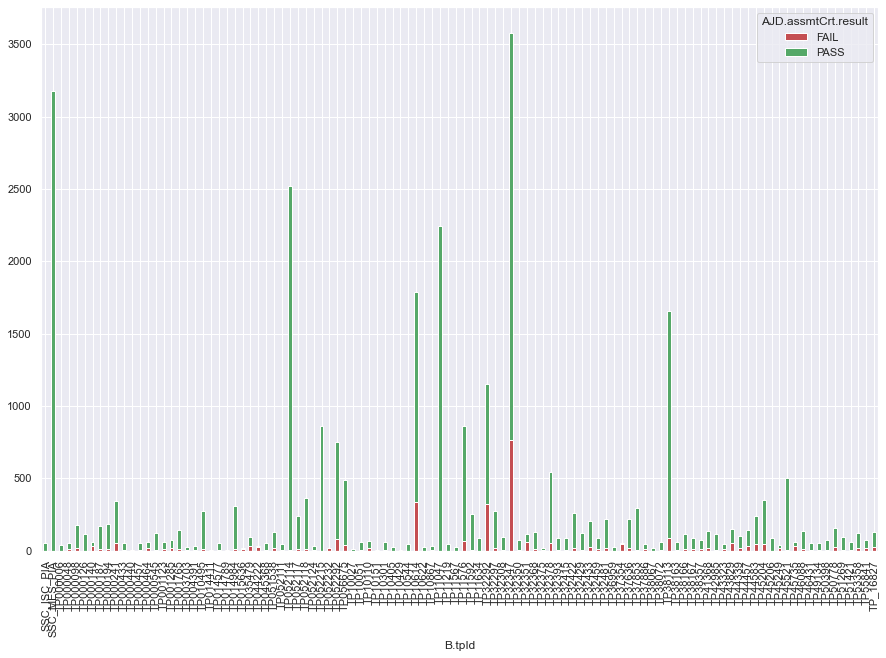

In [10]:
data_pass_fail.set_index('B.tpId').plot(kind='bar', stacked=True, color=["r","g"])

In [11]:
data_pass_fail2 = data_pass_fail.sort_values(by = ['PASS','FAIL'], ascending = False).head(20)

<AxesSubplot:xlabel='B.tpId'>

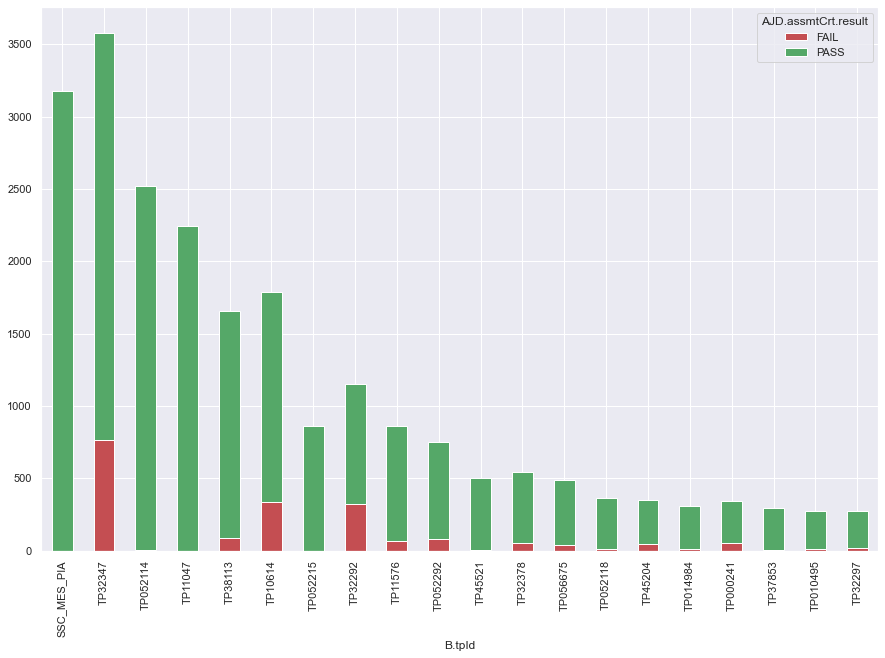

In [12]:
data_pass_fail2.set_index('B.tpId').plot(kind='bar', stacked=True, color=["r","g"])

The dataframe is sorted by the top 20 trainers who have shown highest amount of pass percentages. We see that when we sort the data based on the pass % we find that the SSC_MES_PIA trainer opes the list with more pass candidates

## 3. Count the number of unique "B.sector.name", "B.address.district.name", "B.batchName", and "C.candidateId" per training provider.

In [13]:
trainer_count = data.groupby('B.tpId')['B.sector.name','B.address.district.name','B.batchName','C.candidateId'].nunique().reset_index()
trainer_count2 = trainer_count.sort_values(by = ['B.sector.name', 'B.address.district.name', 'B.batchName', 'C.candidateId'], ascending = False)

/var/folders/r6/1g8m0xd94_7blqsglzmqftd40000gn/T/ipykernel_8787/2327570179.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trainer_count = data.groupby('B.tpId')['B.sector.name','B.address.district.name','B.batchName','C.candidateId'].nunique().reset_index()


In [14]:
trainer_count2.head()

,B.tpId,B.sector.name,B.address.district.name,B.batchName,C.candidateId
47,TP10614,10,1,85,1789
56,TP32292,6,4,38,1155
64,TP32378,5,4,17,543
74,TP37636,5,3,7,221
20,TP010495,4,4,10,272


In [15]:
#Getting the top 20 trainers based on the sector name, district name and just plotting in graph
trainer_count3 = trainer_count2.head(20)

<AxesSubplot:xlabel='B.tpId'>

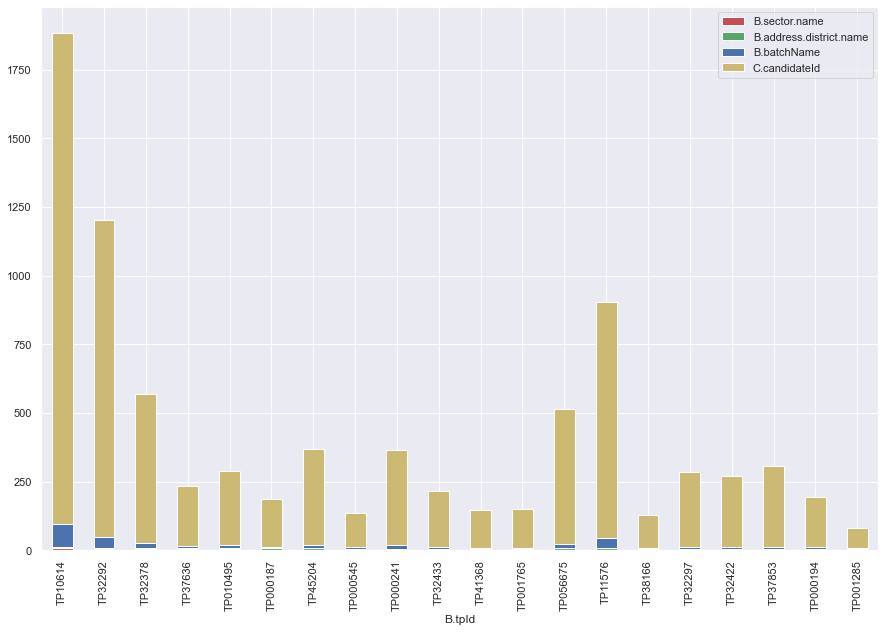

In [16]:
trainer_count3.set_index('B.tpId').plot(kind='bar', stacked=True, color=["r","g","b","y"])

This is one additional representation of the trainers sorted on the basis of sector name, districtname, batch name, and candidate id

## 4. Calculate the median of assessment score and percentage of candidates who pass the assessment test per training provider.  

In [17]:
data_perc = data[['B.tpId', 'AJD.assmtCrt.percentage', 'AJD.assmtCrt.result']]

In [18]:
data_perc_2 = pd.DataFrame(data_perc.groupby('B.tpId')['AJD.assmtCrt.percentage'].median().fillna(0).reset_index())

In [19]:
data_pass_fail['Pass_percent'] = data_pass_fail['PASS']/(data_pass_fail['PASS'] + data_pass_fail['FAIL'])

In [20]:
tpid_pass_median = pd.concat([data_perc_2,data_pass_fail], keys = 'B.tpId', axis = 1, ignore_index = True)
tpid_pass_median = tpid_pass_median[[0,1,5]]
tpid_pass_median.columns = ['TP_id','Median_percentage','Pass_percentage']

In [21]:
tpid_pass_median.sort_values(by = ['Pass_percentage', 'Median_percentage'], ascending = False).head()

,TP_id,Median_percentage,Pass_percentage
51,TP11219,89.20,1.0
1,SSC_MES_PIA,88.05,1.0
77,TP38067,86.99,1.0
52,TP11567,86.75,1.0
44,TP10405,86.67,1.0


For each trainer, the median pass assessment scores and the percentage of people who passed are taken and then sorted inthe respective order

## 5. Use the result of question 3 as inputs (4 inputs) and question 4 as outputs (2 outputs) of DEA model parameters. Solve the linear optimization problems per training provider given the set of inputs and output. 

In [22]:
trainer_count2.rename(columns = {'B.tpId' : 'TP_id', 'B.sector.name' :'Sector_name', "B.batchName":"batch_name",
                                "C.candidateId":"candidate_id", "B.address.district.name": "district_name"}, inplace = True)

In [23]:
trainer_list = list(trainer_count2['TP_id'].unique())

In [24]:
optim_df = pd.merge(tpid_pass_median,trainer_count2, on='TP_id').set_index('TP_id').fillna(0)
optim_df.rename(columns = {'Median_percentage':'x5', 'Pass_percentage':'x6','Sector_name':'x1', 'district_name':'x2',
       'batch_name':'x3', 'candidate_id' :'x4'}, inplace = True)
optim_df2 = optim_df.transpose()
inputs = optim_df2.to_dict()

In [25]:
hosts = []
perfs = []
from pulp import *

performance=dict()

# decision variables
output_Ingredients=['x5','x6']
input_Ingredients=['x1','x2','x3','x4']


output_vars = LpVariable.dicts("O", output_Ingredients, 0)
input_vars = LpVariable.dicts("I", input_Ingredients, 0)

for host in trainer_list:
    prob = LpProblem("Branch Utilization Probelm Problem", LpMaximize)

    #Objective 
    prob += (
        lpSum([inputs[host][i] * output_vars[i] for i in output_Ingredients]),
        "Utilization of Branch 1",
    )


    for h in trainer_list:
        prob += (
            lpSum([inputs[h][i] * output_vars[i] for i in output_Ingredients]+[-inputs[h][i] * input_vars[i] for i in input_Ingredients ]) <= 0,
            "{}".format(h)
        )

    #Constraints
    prob += lpSum([inputs[host][i] * input_vars[i] for i in input_Ingredients]) == 1, "Norm"        

    print("_____________________LP- Branch: {}_____________________".format(host))    

    prob.writeLP("DEA_Branch.{}_Model.lp".format(h))


    print("______________________Solution_________________________")

    prob.solve()
    print("Status:", LpStatus[prob.status])
    

    for v in prob.variables():
        print(v.name, "=", v.varValue)
    
    hosts.append(host)
    perfs.append(value(prob.objective))
    trainer_perf = {'tpId': hosts,'Perf': perfs}

    print("Optimal Utilization of Branch {} = ".format(host), value(prob.objective))

    print("__________________________ Dual Variables _______________")

    for name, c in list(prob.constraints.items()):
        print(name, ":", "\t Dual:", c.pi  )

/Users/kensaroven/opt/anaconda3/lib/python3.9/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


_____________________LP- Branch: TP10614_____________________
______________________Solution_________________________
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/kensaroven/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r6/1g8m0xd94_7blqsglzmqftd40000gn/T/3824d9c44a6e43d29eba3731b5266f87-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/r6/1g8m0xd94_7blqsglzmqftd40000gn/T/3824d9c44a6e43d29eba3731b5266f87-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 112 COLUMNS
At line 747 RHS
At line 855 BOUNDS
At line 856 ENDATA
Problem MODEL has 107 rows, 6 columns and 632 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 104 (-3) rows, 6 (0) columns and 620 (-12) elements
0  Obj -0 Primal inf 0.00055797149 (1) Dual inf 1450.397 (2)
11  Obj 0.82666294
Optimal - objective value 0.82666294
After P

In [26]:
perf_df  = pd.DataFrame(trainer_perf)
perf_df.sort_values(by = 'Perf', ascending = False).head(20)

,tpId,Perf
94,TP11567,1.000000
64,TP11634,1.000000
50,TP052215,1.000000
80,TP10544,1.000000
86,TP11219,1.000000
87,TP000006,1.000000
39,TP11047,1.000000
68,TP45206,1.000000
42,SSC_MES_PIA,1.000000
84,SSC_ISC_PIA,1.000000


The model reveals us the performance of each trainer based on the inputs and the outputs fed to it, which can be seen from the dataframe printed above

## 6. Based on the results, identify low and top-efficient training providers. 

In [27]:
perf_df['Eff_flag'] = np.where(perf_df['Perf']>=0.9, 'Efficient', 'Inefficient')

In [28]:
perf_df[perf_df['Eff_flag'] == 'Efficient'].count()

tpId        48
Perf        48
Eff_flag    48
dtype: int64

In [29]:
48/106

0.4528301886792453

We have put a cap of 90% as a performance indicator to filter the trainers where the performance is 90%. With this wee see that out of the 106 trainers only 48 seem to achieve the best output overall, which is 45% of the total trainers.

## 7. Based on the DEA results, identify different approaches that can be deployed to make the skilling ecosystem more efficient. 

From our analysis, we identify that 55% of the total trainers are inefficient.

For these 55% of the trainers, we need to make sure that we train them necessarily. Some of the measures we can take some of the initiatives such as -

    1. We need to monitor the classes conducted by these professors and then understand the flaws potentially notable inthese trainer classes
    
    2. In addition, we can compare the profiles of the candidates who participate in the lecture category with a successful trainer and these two trainers take either the similar courses or the similar courses from the same category
    
    3. Moreover, we can see that QPS.qpParamOne.paramDesc, QPS.qpParamTwo.paramDesc, and QPS.qpParamThree.paramDesc denote the cateogry of the course we can use in our optimization to gain more reasonable insights
    
    4. Jobname denotes the name of the which the candidate is trained, and NsqfLevel denotes the national skills qualification level as well which we can use in our analysis to identify the level and identify if the dropouts is specific to the skill level and we can target those category course more specifically. The same could be achieved using the pre training status, age, gender, candidate from home state,  and the employed status to get course level insights further.
    
    5. For the efficient and inefficient trainers, we can analyse the number of candidates enrolled in their course to understand if it is candidate enrollment that can cause the issue for these folks.


# Alternate Approach - For Q5

In [30]:
#Input
sector_num = dict([(i,a) for i,a in zip(trainer_count2['TP_id'],trainer_count2['Sector_name'])])
district_num = dict([(i,a) for i,a in zip(trainer_count2['TP_id'],trainer_count2['district_name'])])
batch_num = dict([(i,a) for i,a in zip(trainer_count2['TP_id'],trainer_count2['batch_name'])])
candidate_num = dict([(i,a) for i,a in zip(trainer_count2['TP_id'],trainer_count2['candidate_id'])])

#Output
median_score_num = dict([(i,a) for i,a in zip(tpid_pass_median['TP_id'],tpid_pass_median['Median_percentage'])])
pass_percent_num = dict([(i,a) for i,a in zip(tpid_pass_median['TP_id'],tpid_pass_median['Pass_percentage'])])

### Decision Variable

In [31]:
prob = pulp.LpProblem("Trainer_Resource_utilization_probelm", sense = LpMaximize)

### Defining Decision Variable

In [32]:
#Inputs
x1 = pulp.LpVariable.dict("sector",trainer_list, lowBound=0, upBound=None, cat = 'Continuous')
x2 = pulp.LpVariable.dict("district",trainer_list, lowBound=0, upBound=None, cat = 'Continuous')
x3 = pulp.LpVariable.dict("batch",trainer_list,lowBound=0, upBound=None, cat = 'Continuous')
x4 = pulp.LpVariable.dict("candidate",trainer_list,lowBound=0, upBound=None, cat = 'Continuous')

#Outputs
x5 = pulp.LpVariable.dict("median_score",trainer_list,lowBound=0, upBound=None, cat = 'Continuous')
x6 = pulp.LpVariable.dict("percent_pass",trainer_list,lowBound=0, upBound=None, cat = 'Continuous')

### Objective function and Adding constraints

In [33]:
performance = dict()
#variables = dict()

for i in trainer_list:
    # Objective
    prob += pulp.lpSum(median_score_num[i] * x5[i] + pass_percent_num[i] * x6[i])

    # Constraints
    prob += pulp.lpSum(median_score_num[i] * x5[i] + pass_percent_num[i] *x6[i] - sector_num[i] *x1[i] - district_num[i]*x2[i] - batch_num[i]*x3[i] - candidate_num[i]*x4[i]) <= 0
        
    prob += pulp.lpSum(sector_num[i]*x1[i] + district_num[i]*x2[i] + batch_num[i]*x3[i] + candidate_num[i]*x4[i]) == 1

    print("_____________________LP - Trainer: {}_____________________".format(i))  
    print(prob)    

    #prob.writeLP("DEA_trainer_{}_Model.lp".format(i))


    print("______________________Solution_________________________")

    prob.solve()
    print("Status:", LpStatus[prob.status])
    
    for v in prob.variables():
        variables.update({v.name:v.varValue}) #variables = dict(zip(v.name, v.varValue)) #variables[v.name].append(v.varValue) variables.update({v.name:v.varValue})
    
    for v in prob.variables():
        print(v.name, "=", v.varValue)

    print("Optimal efficiency of trainer {} = ".format(i), pulp.value(prob.objective))

    print("__________________________ Dual Variables _______________")

    for name, c in list(prob.constraints.items()):
        print(name, ":", "\t Dual:", c.pi  )
        
    performance[i]= pulp.value(prob.objective)


_____________________LP - Trainer: TP10614_____________________
Trainer_Resource_utilization_probelm:
MAXIMIZE
74.33*median_score_TP10614 + 0.8138624930128563*percent_pass_TP10614 + 0.0
SUBJECT TO
_C1: - 85 batch_TP10614 - 1789 candidate_TP10614 - district_TP10614
 + 74.33 median_score_TP10614 + 0.813862493013 percent_pass_TP10614
 - 10 sector_TP10614 <= 0

_C2: 85 batch_TP10614 + 1789 candidate_TP10614 + district_TP10614
 + 10 sector_TP10614 = 1

VARIABLES
batch_TP10614 Continuous
candidate_TP10614 Continuous
district_TP10614 Continuous
median_score_TP10614 Continuous
percent_pass_TP10614 Continuous
sector_TP10614 Continuous

______________________Solution_________________________
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/kensaroven/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r6/1g8m0xd94_7blqsglzmqftd40000gn/T/e39a56ddac01446f8ebcca489119715e-pulp.mps max timeMode elapsed branch printingOp

NameError: name 'variables' is not defined

In [ ]:
variables

{'batch_TP10614': 0.011764706,
 'candidate_TP10614': 0.0,
 'district_TP10614': 0.0,
 'median_score_TP10614': 0.0,
 'percent_pass_TP10614': 0.0,
 'sector_TP10614': 0.0,
 'batch_TP32292': 0.026315789,
 'candidate_TP32292': 0.0,
 'district_TP32292': 0.0,
 'median_score_TP32292': 0.0,
 'percent_pass_TP32292': 0.0,
 'sector_TP32292': 0.0,
 'batch_TP32378': 0.058823529,
 'candidate_TP32378': 0.0,
 'district_TP32378': 0.0,
 'median_score_TP32378': 0.0,
 'percent_pass_TP32378': 0.0,
 'sector_TP32378': 0.0,
 'batch_TP37636': 0.14285714,
 'candidate_TP37636': 0.0,
 'district_TP37636': 0.0,
 'median_score_TP37636': 0.0,
 'percent_pass_TP37636': 0.0,
 'sector_TP37636': 0.0,
 'batch_TP010495': 0.1,
 'candidate_TP010495': 0.0,
 'district_TP010495': 0.0,
 'median_score_TP010495': 0.0,
 'percent_pass_TP010495': 0.0,
 'sector_TP010495': 0.0,
 'batch_TP000187': 0.16666667,
 'candidate_TP000187': 0.0,
 'district_TP000187': 0.0,
 'median_score_TP000187': 0.0,
 'percent_pass_TP000187': 0.0,
 'sector_TP0001

In [ ]:
# Print the performance of each trainer
for i in performance.items():
    print(i)

('TP10614', 1.000000007154835)
('TP32292', 0.9999999761904761)
('TP32378', 0.9999999876611418)
('TP37636', 1.0000000113122172)
('TP010495', 1.0000000474264705)
('TP000187', 0.9999999537572254)
('TP45204', 1.0000000022857143)
('TP000545', 1.0000000352)
('TP000241', 1.000000023699422)
('TP32433', 0.9999999844660195)
('TP41368', 0.9999999963503651)
('TP001765', 1.0000000384615384)
('TP056675', 0.9999999967213116)
('TP11576', 1.0000000130232558)
('TP38166', 0.9999999652542373)
('TP32297', 0.9999999912087911)
('TP32422', 1.0000000272373541)
('TP37853', 0.9999999696969696)
('TP000194', 1.0000000109289617)
('TP001285', 1.000000002)
('TP10051', 1.00000004)
('TP10301', 1.0000000199999999)
('TP000464', 0.9999999830508474)
('TP000048', 0.999999979245283)
('TP44583', 0.9999999904166665)
('TP000098', 0.9999999916201117)
('TP42985', 1.0000000341880342)
('TP43829', 0.9999999834437086)
('TP44457', 0.9999999616438356)
('TP46088', 1.0000000000000002)
('TP32351', 1.0000000132743363)
('TP035479', 1.000000

In [34]:
variables = dict([(i,a) for i,a in zip(keys,value)])

NameError: name 'keys' is not defined

In [ ]:
inc = iter(variables.items())
batch = dict(islice(inc, len(variables) // 6))
rest1 = dict(inc)

inc2 = iter(rest1.items())
candidate = dict(islice(inc2, len(rest1) // 5))
rest2 = dict(inc2)

inc3 = iter(rest2.items())
district = dict(islice(inc3, len(rest2) // 4))
rest3 = dict(inc3)

inc4 = iter(rest3.items())
median_score = dict(islice(inc4, len(rest3) // 3))
rest4 = dict(inc4)

inc5 = iter(rest4.items())
percent_pass = dict(islice(inc5, len(rest4) // 2))
sector = dict(inc5)

In [ ]:
df_results = pd.DataFrame(pd.concat({'batch':pd.Series(batch),'candidate':pd.Series(candidate),
             'district':pd.Series(district),'median_score':pd.Series(median_score),
             'percent_pass':pd.Series(percent_pass), 'sector': pd.Series(sector)}, axis = 0).reset_index())
df_results.columns = ['Var','ID','perf']

In [ ]:
df_results.head()

,Var,ID,perf
0,batch,batch_SSC_ISC_PIA,0.000000
1,batch,batch_SSC_MES_PIA,0.016667
2,batch,batch_TP000006,0.000000
3,batch,batch_TP000048,0.000000
4,batch,batch_TP000098,0.000000


In [ ]:
bat = df_results[df_results['Var']=='batch']
bat['trainer'] = bat['ID'].str[len('batch')+1:]
can = df_results[df_results['Var']=='candidate']
can['trainer'] = can['ID'].str[len('candidate')+1:]
dis = df_results[df_results['Var']=='district']
dis['trainer'] = dis['ID'].str[len('district')+1:]
med = df_results[df_results['Var']=='median_score']
med['trainer'] = med['ID'].str[len('median_score')+1:]
per = df_results[df_results['Var']=='percent_pass']
per['trainer'] = per['ID'].str[len('percent_pass')+1:]
sec = df_results[df_results['Var']=='sector']
sec['trainer'] = sec['ID'].str[len('sector')+1:]

/var/folders/r6/1g8m0xd94_7blqsglzmqftd40000gn/T/ipykernel_73532/1112316181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bat['trainer'] = bat['ID'].str[len('batch')+1:]
/var/folders/r6/1g8m0xd94_7blqsglzmqftd40000gn/T/ipykernel_73532/1112316181.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can['trainer'] = can['ID'].str[len('candidate')+1:]
/var/folders/r6/1g8m0xd94_7blqsglzmqftd40000gn/T/ipykernel_73532/1112316181.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [ ]:
a1 = bat.merge(can, on = 'trainer')
a2 = a1.merge(dis, on = 'trainer')
a3 = a2.merge(med, on = 'trainer')
a4 = a3.merge(per, on = 'trainer')
a5 = a4.merge(sec, on = 'trainer')

fin_var = a5.drop(a5.columns[[1,5, 8,11, 14, 17]],axis = 1)
#pd.melt(fin_var, id_vars = ['trainer','level_0'], value_name = 0, value_vars = 0)
fin_var.columns = ['Batch','batch_score','trainer','Candidate','candidate_score','district','district_score', 
                   'median', 'median_score', 'pass_per', 'pass_per_score', 'sector', 'sector_score']
fin_var = fin_var[['trainer', 'batch_score','candidate_score', 'district_score','median_score','pass_per_score','sector_score']]
fin_var.head()

/Users/kensaroven/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ID_x', 'Var_x', 'perf_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


,trainer,batch_score,candidate_score,district_score,median_score,pass_per_score,sector_score
0,SSC_MES_PIA,0.016667,0.000000,0.0,0.000000,1.000000,0.0
1,TP000006,0.000000,0.024390,0.0,0.012469,0.000000,0.0
2,TP000048,0.000000,0.018868,0.0,0.000000,1.292683,0.0
3,TP000098,0.000000,0.000000,0.0,0.000000,1.098159,0.5
4,TP000126,0.250000,0.000000,0.0,0.000000,1.000000,0.0


In [ ]:
fin_var['out_sum'] = fin_var['median_score'] +fin_var['pass_per_score']
fin_var['inp_sum'] = fin_var['batch_score'] +fin_var['candidate_score'] + fin_var['district_score'] +fin_var['sector_score']
fin_var.sort_values(by= 'inp_sum', ascending = False).head()

,trainer,batch_score,candidate_score,district_score,median_score,pass_per_score,sector_score,out_sum,inp_sum
94,TP50778,0.0,0.0,0.0,0.012384,0.000000,1.0,0.012384,1.0
9,TP000433,0.0,0.0,0.0,0.000000,1.133333,1.0,1.133333,1.0
72,TP38072,0.0,0.0,1.0,0.000000,1.072727,0.0,1.072727,1.0
62,TP32429,0.0,0.0,1.0,0.012913,0.000000,0.0,0.012913,1.0
56,TP32368,0.0,0.0,0.0,0.000000,1.074380,1.0,1.074380,1.0


In [ ]:
batch_key =[]
batch_value =[]
for key, val in zip(keys, value):
    if str(batch) in str(key):
        batch_key.append(key)
        batch_key.append(val)

In [ ]:
print("Total Cost = ", value(prob.objective))

TypeError: 'list' object is not callable

In [ ]:
performance = {}
for v in trainer_list:
    performance[v] = value(prob.objective)

TypeError: 'list' object is not callable

In [ ]:
# Dual Variables
for name, c in list(prob.constraints.items()):
    print(name, ":", c, "\t Dual:", c.pi, "\t Slack:", c.slack)